## Libraries and Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

## Global variables

In [2]:
#global variables
min_date_train='2018-01-01'
max_date_train='2018-01-31'
min_date_predict='2018-02-01'
max_date_predict='2018-02-28'

## Loading data

In [3]:
features = ["date","time","flow","anomaly"]
df = pd.read_csv('barreiro_ano.csv', sep=';', names=features)
holidays = pd.read_csv('holidays2018.csv',sep=';')

## Dataset changes

In [4]:
#convert column to date time
df['date'] = pd.to_datetime(df['date'])
holidays['date'] = pd.to_datetime(holidays['date'])

In [5]:
#extra column indicating day of week
#0: mon, 1:tue, ..., 5:sat, 6:sun
df['dayofweek'] = pd.to_datetime(df['date'],dayfirst=True)
df['dayofweek'] = df['dayofweek'].dt.dayofweek

In [6]:
# if day is a holiday, then dayofweek is -1
df.loc[df.date.isin(holidays.date), 'dayofweek'] = -1

## Time in indexes

In [7]:
'''
to transform the time in indexes
'''
#def time_in_indexes(df):

# to extract all unique values (time) present in dataframe
time_unique_val=df.time.unique()
# in order to accept time series with different periods per day
periods_per_day=len(time_unique_val)
time_unique_ind=np.arange(periods_per_day)
#in order to have a mapping between the time of day and its index
time_unique=pd.DataFrame({'time':time_unique_val, 'time_unique_ind':time_unique_ind})
#creates a column with the time index
df['time_ind'] = df['time'].map(time_unique.set_index('time')['time_unique_ind'])

#    return df

## Lags of time series

In [8]:
'''
to transform a time series data into a supervised learning problem
'''
def lags_time_series(df,D):
    df_lagged=df.copy()
    number_lags=D
    for i in range(1, number_lags+1):
        shifted=df['flow'].shift(i)
        df_lagged=pd.concat((df_lagged, shifted), axis=1)
    # just to label the columns of the resulting dataframe
    lagged_cols=["n-"+ str(x) for x in range(1,number_lags+1)]
    colnames= ["date","time","flow","anomaly", "time_ind","dayofweek"]+lagged_cols
    df_lagged.columns=colnames
    # in order to drop the rows corresponding do the first day
    #to get rid of the NaN values
    df_lagged =  df_lagged.iloc[periods_per_day:]
    return df_lagged

In [9]:
df_lagged=lags_time_series(df,10)

In [10]:
#df_weekdays: contains data related to weekdays 
#df_sat: contains data related to saturdays
#df_sun: contains data related to sundays and holidays
df_weekdays = df_lagged[(df_lagged['dayofweek']>=0) & (df_lagged['dayofweek']<=4)]
df_sat = df_lagged[df_lagged['dayofweek']==5]
df_sun = df_lagged[(df_lagged['dayofweek']==-1) | (df_lagged['dayofweek']==6)]

## Create data

In [11]:
#get data to train a particular period (first of the day, eg)
'''
to create a dataframe that can be used to train a model
we should choose a range of dates (min_date, max_date)
a typeofdate ('weekdays', 'saturdays', 'sundays' (this one includes holidays))
and a period of the day (time_ind that can range from 0 to periods_per_day)
'''
def create_data_for_model(min_date, max_date, typeofday, time_ind):
    if typeofday=='weekdays':
        sel_data=df_weekdays[(df_weekdays.date>=min_date) & (df_weekdays.date<=max_date)]
    elif typeofday=='saturdays':
        sel_data=df_sat[(df_sat.date>=min_date) & (df_sat.date<=max_date)]
    else:
        sel_data=df_sun[(df_sun.date>=min_date) & (df_sun.date<=max_date)]
        sel_data=sel_data[sel_data['time_ind']==time_ind]
    return sel_data

Porque temos de especificar as datas, se no inicio do script temos 4 variáveis com as mesmas?

In [12]:
#an example, just to test
data=create_data_for_model('2018-01-01', '2018-01-31', 'weekdays', 0)
#data

In [13]:
y=data['flow'].copy()
X=data.iloc[:,6:] #contains only the D previous values

## GridSearchCV

In [14]:
# to look for the best SVR parameters
'''
to get the best set of parameters for the SVR model
'''
def grid_search(X,y):
    # SVR model
    model=svm.SVR()
    # dict of parameters
    parameters={'kernel':['rbf'], 'gamma':['auto','scale'], 'C':[0.1, 1, 10]} # 'epsilon':[0.01,0.05,0.5,1]
    # strategy to evaluate the performance of the cross-validated mode on the test set
    scorer=make_scorer(mean_squared_error, greater_is_better=False)
    # Build and fit the GridSearchCV
    grid = GridSearchCV(estimator=model, param_grid=parameters, scoring=scorer, cv=KFold(n_splits=5))
    grid_results = grid.fit(X, y)
    # in order to return the best set of parameters
    best_param=grid_results.cv_results_['params'][grid_results.best_index_]   
    return best_param

In [15]:
# just to test
params=[]
params=grid_search(X,y)
params

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

## SVR model

In [16]:
"""
data: dataframe containing data for a specific type of day and 
for a specific time_ind
"""
def svr_model(X,y,params,epsilon):
    # 70% train, 30% test
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)
    # in order to fetch the parameter values
    svr_model = svm.SVR(C=params['C'], epsilon=epsilon, gamma=params['gamma'], kernel=params['kernel'])
    svr_model.fit(X_train, y_train)
    return svr_model

## Regressors

In [17]:
# creates a model for each period for weekdays
# for  a min_date-max_date range
# the result is a dataframe with as many rows as periods_per_day
# each containing a regressor
def creates_regressors_weekdays(min_date, max_date):
    regressors_weekdays = []
    
    for i in range(periods_per_day):
        data=create_data_for_model(min_date, max_date, 'weekdays', i)
        epsilon=data['flow'].std()*0.5
        regressors_weekdays.append(svr_model(X,y,params,epsilon))
    return regressors_weekdays

Porque é que o regressor de sábados e domingos está como weekdays em 'data'?

In [18]:
# creates a model for each period for saturdays
# for  a min_date-max_date range
# the result is a dataframe with as many rows as periods_per_day
# each containing a regressor
def creates_regressors_saturdays(min_date, max_date):
    regressors_saturdays = []
    
    for i in range(periods_per_day):
        data=create_data_for_model(min_date, max_date, 'weekdays', i)
        epsilon=data['flow'].std()*0.5
        regressors_saturdays.append(svr_model(X,y,params,epsilon))
    return regressors_saturdays

In [19]:
# creates a model for each period for sundays and holidays
# for  a min_date-max_date range
# the result is a dataframe with as many rows as periods_per_day
# each containing a regressor
def creates_regressors_sundays(min_date, max_date):
    regressors_sundays = []
    
    for i in range(periods_per_day):
        data=create_data_for_model(min_date, max_date, 'weekdays', i)
        epsilon=data['flow'].std()*0.5
        regressors_sundays.append(svr_model(X,y,params,epsilon))
    return regressors_sundays

In [20]:
# for testing, we will use 2018-01-01 to 2018-01-31 for
# constructing regressors
regressors_weekdays=creates_regressors_weekdays(min_date_train, max_date_train)
regressors_saturdays=creates_regressors_saturdays(min_date_train, max_date_train)
regressors_sundays=creates_regressors_weekdays(min_date_train, max_date_train)

## Standard deviation

In [21]:
def creates_std_sets(min_date, max_date, regressor):
    std=[]
    if regressor=='weekdays':
        for i in range(periods_per_day):
            data=create_data_for_model(min_date,max_date, 'weekdays', i)
            std.append(data['flow'].std())
    if regressor=='saturdays':
        for i in range(periods_per_day):
            data=create_data_for_model(min_date,max_date, 'saturdays', i)
            std.append(data['flow'].std())
    else:
        for i in range(periods_per_day):
            data=create_data_for_model(min_date,max_date, 'sundays', i)
            std.append(data['flow'].std())
    return std

In [22]:
std_weekdays=creates_std_sets(min_date_train, max_date_train,'weekdays')
std_saturdays=creates_std_sets(min_date_train, max_date_train,'saturdays')
std_sundays=creates_std_sets(min_date_train, max_date_train,'sundays')

## Forecasting

In [23]:
def predict_flow(df):
    predictions=[]
    for i in range(len(df)):
        if ((df.iloc[i,5]>=0) and (df.iloc[i,5] <=4)):
            model=regressors_weekdays[df.iloc[i,4]]
            predictions.append(model.predict(df.iloc[i:i+1,6:]))
        elif (df.iloc[i,5]==5): # i.e. saturdays
            model=regressors_saturdays[df.iloc[i,4]]
            predictions.append(model.predict(df.iloc[i:i+1,6:]))
        else: #i.e., sundays and holidays
            model=regressors_sundays[df.iloc[i,4]]
            predictions.append(model.predict(df.iloc[i:i+1,6:]))
      
    return predictions

In [24]:
df2predict=df_lagged[(df_lagged.date>=min_date_predict) & (df_lagged.date<=max_date_predict)]

In [29]:
df2predict

,date,time,flow,anomaly,time_ind,dayofweek,n-1,n-2,n-3,n-4,n-5,n-6,n-7,n-8,n-9,n-10
96,2018-02-01,00:07:30,15.008750,0,3,0,16.586483,17.434139,17.016261,16.916267,16.770839,21.292067,22.624994,21.542819,22.036933,23.194106
97,2018-02-01,00:22:30,13.375950,0,3,1,15.008750,16.586483,17.434139,17.016261,16.916267,16.770839,21.292067,22.624994,21.542819,22.036933
98,2018-02-01,00:37:30,12.083542,0,3,2,13.375950,15.008750,16.586483,17.434139,17.016261,16.916267,16.770839,21.292067,22.624994,21.542819
99,2018-02-01,00:52:30,12.161200,0,3,3,12.083542,13.375950,15.008750,16.586483,17.434139,17.016261,16.916267,16.770839,21.292067,22.624994
100,2018-02-01,01:07:30,25.701713,0,3,4,12.161200,12.083542,13.375950,15.008750,16.586483,17.434139,17.016261,16.916267,16.770839,21.292067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32251,2018-02-12,22:52:30,22.724222,0,0,91,23.162828,23.313772,22.032644,24.859133,25.712639,27.261311,29.807828,29.413200,31.220794,32.902628
32252,2018-02-12,23:07:30,18.846494,0,0,92,22.724222,23.162828,23.313772,22.032644,24.859133,25.712639,27.261311,29.807828,29.413200,31.220794
32253,2018-02-12,23:22:30,16.409161,0,0,93,18.846494,22.724222,23.162828,23.313772,22.032644,24.859133,25.712639,27.261311,29.807828,29.413200
32254,2018-02-12,23:37:30,17.070800,0,0,94,16.409161,18.846494,22.724222,23.162828,23.313772,22.032644,24.859133,25.712639,27.261311,29.807828


In [25]:
y_true=df2predict['flow']
y_pred=predict_flow(df2predict)

In [26]:
# to choose what we want to forecast (number of days)
def predict_days(y_true, y_pred, day):
    yTrue=[]
    yPred=[]
    if day==1:
        yTrue=y_true[0:periods_per_day] # to look at 1 day
        yPred=y_pred[0:periods_per_day]
    else:
        yTrue=y_true[0:periods_per_day*day]
        yPred=y_pred[0:periods_per_day*day]
    
    x = np.linspace(0,len(yPred),len(yPred)) 
    plt.plot(x, yTrue, label='predicted with SVR')
    plt.plot(x, yPred, label='real value')
    plt.xlabel('time (in periods of 15 min)')
    plt.ylabel('water flow')
    plt.title("Comparing real and predicted values for 1 day (2018-02-01)")
    plt.legend()
    plt.show()
    
    # evaluation metrics
    error = mean_squared_error(yTrue, yPred)
    result= print('RBF model Test MSE: %.3f' % error)
    
    return result

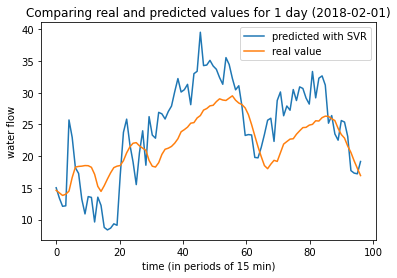

RBF model Test MSE: 30.397


In [27]:
# just to test
predict_1d=predict_days(y_true, y_pred, 1)

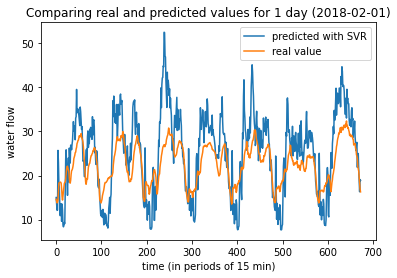

RBF model Test MSE: 44.463


In [28]:
predict_7d=predict_days(y_true, y_pred, 7)

## Evaluation metrics

In [ ]:
# Mean squared error function loss
# The mean_squared_error function computes mean square error, a risk metric corresponding to the expected value of the squared (quadratic) error or loss
# error = mean_squared_error(y_test, y_pred)
# print('RBF model Test MSE: %.3f' % error)

## Anomaly detection

In [29]:
# example
y_true=y_true[0:periods_per_day] 
y_pred=y_pred[0:periods_per_day]

In [ ]:
"""
a surprise occurs when the difference between the observed and predicted value is more than a given number - tolerance or threshold
"""
def surprise(y_pred, y_true, std_weekdays):
    # to create the suprise column in df
    df[surprise]= ""
    # difference between SVR model prediction and actual values
    difference= y_pred - y_true
    difference=abs(difference)
    # quantile
    thresh= 5*std_weekdays
    
    for i in range(y_pred):
        for j in range(y_true):
            if difference>thresh:
            # if it's a surprise = -1
            df.loc[df[j].isin(y_true[j]), 'surprise'] = -1
#    return 

### Sliding window

In [ ]:
def window(df, n):
  
    # h - fixed lower bound of number of surprises
    k = len(df)
    
    # compute sum of first window of sike k
    window_sum = sum(df[:n])
    
    # first sum available
    max_sum = window
    
    # Compute the sums of remaining windows by
    # removing first element of previous
    # window and adding last element of
    # the current window.
    for i in range(k - n):
        window_sum = window_sum - df[i] + df[i + n]
        max_sum = max(window_sum, max_sum)
        
    return max_sum

In [ ]:
test=window(df2predict, 8)